# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs:   0%|          | 0/1646 [00:00<?, ?it/s]

Processing PDBs: 100%|██████████| 1646/1646 [14:37<00:00,  1.88it/s] 


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain_clean/7f58.pdb',
                X           Y           Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     107.904999  121.867996   64.501999   75.06714           3.793293   
 1     104.841003  121.792000   66.737000  121.15404           4.022797   
 2     102.530998  120.727997   63.889999  181.19124           3.814270   
 3     104.267998  117.370003   63.410000  147.13074           3.804284   
 4     103.281998  114.745003   65.971001  146.14594           4.107006   
 ...          ...         ...         ...        ...                ...   
 1017  135.707001   99.641998  154.020004  119.12034           3.800912   
 1018  134.582993  101.835999  156.908997  146.14594           4.005482   
 1019  135.442993  105.522003  156.419998  117.14784           3.814433   
 1020  134.761993  107.310997  159.716995  119.12034           4.256631   
 1021  135.197998  111.084999  159.800995  117.14784           3.800033   
 
       Max_Neighbor_Dist  Neighbor_Count

In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1646 [00:00<?]

# Graph representation vs reality

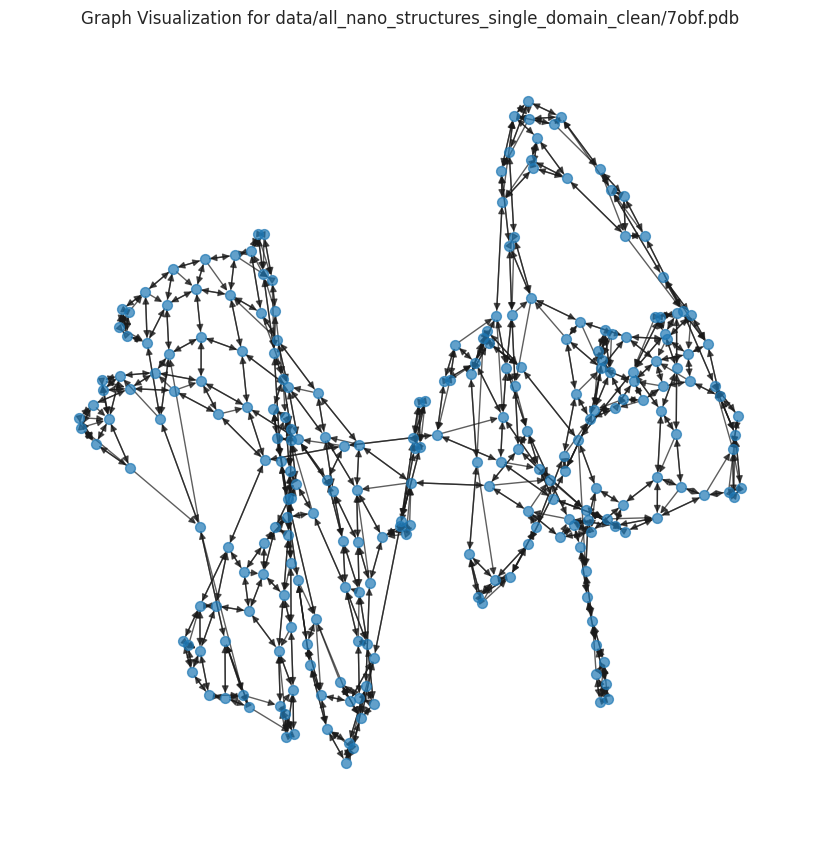

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


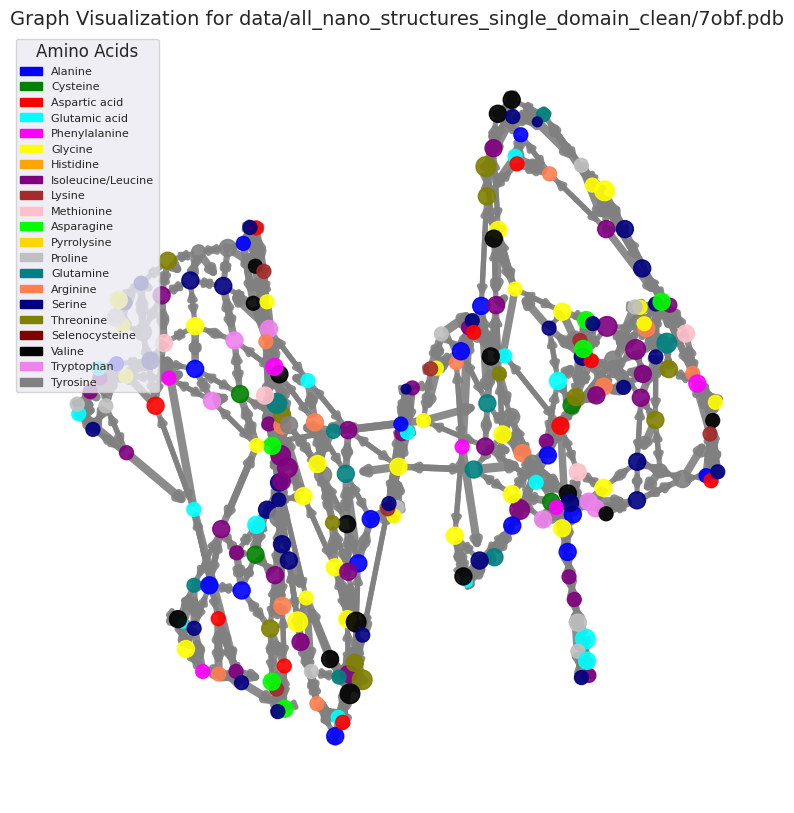

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
# from torch_geometric.loader import DataLoader
# from sklearn.model_selection import train_test_split

# def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
#     """
#     Split the graphs into train and test datasets, and create DataLoaders for batching.

#     Parameters:
#     - graphs (list): List of `torch_geometric.data.Data` graphs.
#     - batch_size (int): Batch size for the DataLoader.
#     - train_ratio (float): Proportion of data to use for training.
#     - seed (int): Random seed for reproducibility.

#     Returns:
#     - train_loader (DataLoader): DataLoader for the training set.
#     - test_loader (DataLoader): DataLoader for the testing set.
#     """
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
    
#     # Split into train and test sets
#     train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
#     # Create DataLoaders
#     train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [16]:
# # Unpack graphs
# graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# # Split and batch the graphs
# train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# # Optional: Keep file names for reference
# pdb_files = [pdb_file for pdb_file, _ in graphs]

# # Example: Iterate through training batches
# for batch in train_loader:
#     print(batch)  # This should now work as expected


# GTA VAE Alex V10

In [20]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [21]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        # Update these weights in the __init__ method
        self.loss_weights = {
            'mass': 0.1,       # Reduced to prevent domination
            'distance': 0.1,   # Reduced for better balance
            'count': 0.1,      # Reduced for better balance
            'small_mol': 0.1,  # Reduced to prevent instability
            'coord': 0.1,      # Kept small for coordinates
            'edge': 0.1        # Reduced for balance
        }

        # Encoder
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(
                in_channels,
                hidden_channels,
                heads=num_heads,
                edge_dim=edge_dim,
                concat=True
            )
        ])

        self.encoder_conv2 = torch.nn.ModuleList([
            GATConv(
                hidden_channels * num_heads,
                hidden_channels,
                edge_dim=edge_dim,
                concat=False
            )
        ])

        # Encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()  # Constrain coordinates
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive mass
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()  # Ensure positive distances
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive count
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)  # No activation - using BCEWithLogitsLoss
        )

        # Edge decoder
        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()  # Ensure positive edge attributes
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Graph convolutions
        for conv in self.encoder_conv1:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        for conv in self.encoder_conv2:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        # Additional feature processing
        x = self.encoder_ff(x)

        # Pool and get latent parameters
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        position_noise = torch.randn_like(z) * 0.05  # Reduced noise
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Decode features
        h = self.shared_decoder(z)

        # Decode node features with specific activations
        coords = self.coord_head(h) * 10  # Scale coordinates
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Decode edge attributes
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6
    
        # Mass loss - using softplus for positive values
        mass_pred = F.softplus(recon[..., self.mass_index])  # Remove clamp
        mass_target = target[..., self.mass_index]
        # Use mean instead of max for more stable scaling
        mass_scale = mass_target.abs().mean() + EPS
        mass_pred_scaled = mass_pred / mass_scale
        mass_target_scaled = mass_target / mass_scale
        losses['mass'] = F.mse_loss(mass_pred_scaled, mass_target_scaled) * self.loss_weights['mass']
    
        # Distance loss
        dist_pred = F.softplus(recon[..., self.distance_indices])  # Remove clamp
        dist_target = target[..., self.distance_indices]
        dist_scale = dist_target.abs().mean() + EPS
        dist_pred_scaled = dist_pred / dist_scale
        dist_target_scaled = dist_target / dist_scale
        losses['distance'] = F.mse_loss(dist_pred_scaled, dist_target_scaled) * self.loss_weights['distance']
    
        # Count loss
        count_pred = F.softplus(recon[..., self.count_index])  # Remove clamp
        count_target = target[..., self.count_index]
        count_scale = count_target.abs().mean() + EPS
        count_pred_scaled = count_pred / count_scale
        count_target_scaled = count_target / count_scale
        losses['count'] = F.mse_loss(count_pred_scaled, count_target_scaled) * self.loss_weights['count']
    
        # Small molecules loss - binary cross entropy
        small_mol_pred = recon[..., self.small_mol_index]  # Remove clamp
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)  # Keep target binary
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred,
            small_mol_target,
            reduction='mean'
        ) * self.loss_weights['small_mol']
    
        # Coordinate loss - no activation needed
        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        coord_scale = coord_target.abs().mean() + EPS
        coord_pred_scaled = coord_pred / coord_scale
        coord_target_scaled = coord_target / coord_scale
        losses['coord'] = F.mse_loss(coord_pred_scaled, coord_target_scaled) * self.loss_weights['coord']
    
        # Edge loss
        edge_pred = F.softplus(edge_recon)  # Remove clamp
        edge_target_pos = F.softplus(edge_target)
        edge_scale = edge_target_pos.abs().mean() + EPS
        edge_pred_scaled = edge_pred / edge_scale
        edge_target_scaled = edge_target_pos / edge_scale
        losses['edge'] = F.mse_loss(edge_pred_scaled, edge_target_scaled) * self.loss_weights['edge']
    
        # Calculate total loss without clamping
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))
    
        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [22]:
def train_model(model, train_loader, test_loader, device, num_epochs=100, beta=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")

    history = {
        'train': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                  'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                  'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []},
        'test': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                 'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                 'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []}
    }

    from tqdm import tqdm
    import time

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses without clamping
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Combine losses without clamping
                loss = recon_loss + beta * kl_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                current_loss = loss.item()
                epoch_losses['total_loss'] += current_loss
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + beta * kl_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            if hasattr(plt, 'figure'):
                plt.figure(figsize=(20, 5))

                # Plot 1: Total, Reconstruction, and KL losses
                plt.subplot(1, 3, 1)
                plt.plot(history['train']['total_loss'], label='Total Loss')
                plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
                plt.plot(history['train']['kl_loss'], label='KL Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                # Plot 2: Feature-specific losses
                plt.subplot(1, 3, 2)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    plt.plot(history['train'][k], label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Feature-specific Losses')
                plt.legend()
                plt.grid(True)

                # Plot 3: Feature-specific losses (log scale)
                plt.subplot(1, 3, 3)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    values = [max(1e-10, abs(x)) for x in history['train'][k]]
                    plt.semilogy(values, label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss (log scale)')
                plt.title('Feature-specific Losses (Log Scale)')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    print("\nTraining completed!")
    return model, history


In [23]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=32,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_conv1): ModuleList(
    (0): GATConv(8, 64, heads=4)
  )
  (encoder_conv2): ModuleList(
    (0): GATConv(256, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True

In [24]:
device=get_device()

/home/lara/Documents/CAS_AML/Projects/M3/m3_venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 1316
Number of test graphs: 330
Number of features per node: 8
Feature means: tensor([-3.5807e-09, -7.0392e-09,  9.9562e-09,  3.1965e-09, -1.9836e-08,
         1.3890e-08,  1.8456e-08, -3.8034e-09])
Feature stds: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Starting training for 10 epochs...
Training on device: cpu
Number of training batches: 83
Number of validation batches: 21


Epoch 1/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([14288, 8])
Edge index shape: torch.Size([2, 57152])
Edge attr shape: torch.Size([57152, 1])
Reconstruction shape: torch.Size([16, 2761, 8])
Edge reconstruction shape: torch.Size([57152, 1])

Detailed loss diagnostics:
Raw recon_loss: 51.0317
Raw KL loss: 0.0029
mu mean: 0.0007, std: 0.0620
logvar mean: 0.0209, std: 0.0577
mass: 2.3581
distance: 2.0510
count: 45.1773
small_mol: 0.0704
coord: 1.2437
edge: 0.1312


Epoch 1/10 [Train]:  12%|█▏        | 10/83 [00:31<03:23,  2.79s/it, loss=4.7028, recon=4.6975, kl=0.0534]   


Detailed loss diagnostics:
Raw recon_loss: 17.4772
Raw KL loss: 0.0708
mu mean: 0.0057, std: 0.3183
logvar mean: 0.2270, std: 0.1389
mass: 1.0585
distance: 0.8909
count: 14.5110
small_mol: 0.0541
coord: 0.8569
edge: 0.1058


Epoch 1/10 [Train]:  24%|██▍       | 20/83 [00:56<03:08,  2.99s/it, loss=29.4650, recon=29.4513, kl=0.1368]


Detailed loss diagnostics:
Raw recon_loss: 94.8199
Raw KL loss: 0.1270
mu mean: 0.0112, std: 0.4208
logvar mean: 0.3124, std: 0.1757
mass: 5.0982
distance: 3.2959
count: 82.4568
small_mol: 0.0312
coord: 3.8327
edge: 0.1051


Epoch 1/10 [Train]:  36%|███▌      | 30/83 [01:32<02:28,  2.81s/it, loss=15.7965, recon=15.7940, kl=0.0258]


Detailed loss diagnostics:
Raw recon_loss: 43.3375
Raw KL loss: 0.0228
mu mean: 0.0095, std: 0.1800
logvar mean: 0.1269, std: 0.0914
mass: 2.5100
distance: 1.7799
count: 38.0508
small_mol: 0.0274
coord: 0.8626
edge: 0.1068


Epoch 1/10 [Train]:  48%|████▊     | 40/83 [02:02<02:16,  3.17s/it, loss=30.5458, recon=30.5450, kl=0.0084]  


Detailed loss diagnostics:
Raw recon_loss: 29.4882
Raw KL loss: 0.0072
mu mean: 0.0075, std: 0.1005
logvar mean: 0.0532, std: 0.0725
mass: 1.6773
distance: 1.2527
count: 25.0191
small_mol: 0.0151
coord: 1.4173
edge: 0.1066


Epoch 1/10 [Train]:  60%|██████    | 50/83 [02:30<01:44,  3.18s/it, loss=21.3154, recon=21.3149, kl=0.0050]


Detailed loss diagnostics:
Raw recon_loss: 89.3680
Raw KL loss: 0.0041
mu mean: 0.0072, std: 0.0734
logvar mean: -0.0135, std: 0.0745
mass: 4.5223
distance: 3.5462
count: 77.4722
small_mol: 0.0127
coord: 3.7074
edge: 0.1072


Epoch 1/10 [Train]:  72%|███████▏  | 60/83 [03:03<01:13,  3.20s/it, loss=18.1019, recon=18.0984, kl=0.0353]


Detailed loss diagnostics:
Raw recon_loss: 19.9834
Raw KL loss: 0.0256
mu mean: 0.0068, std: 0.1711
logvar mean: -0.1854, std: 0.1195
mass: 1.1950
distance: 0.8141
count: 17.1761
small_mol: 0.0266
coord: 0.6624
edge: 0.1093


Epoch 1/10 [Train]:  84%|████████▍ | 70/83 [03:34<00:43,  3.37s/it, loss=35.8005, recon=35.7804, kl=0.2007]


Detailed loss diagnostics:
Raw recon_loss: 21.3409
Raw KL loss: 0.2600
mu mean: -0.0167, std: 0.5441
logvar mean: -0.6951, std: 0.3917
mass: 1.2926
distance: 0.9829
count: 18.3937
small_mol: 0.0156
coord: 0.5500
edge: 0.1060


Epoch 1/10 [Train]:  96%|█████████▋| 80/83 [04:04<00:07,  2.63s/it, loss=29.4862, recon=29.4728, kl=0.1344]


Detailed loss diagnostics:
Raw recon_loss: 33.0891
Raw KL loss: 0.1645
mu mean: -0.0308, std: 0.4113
logvar mean: -0.5560, std: 0.3558
mass: 1.8942
distance: 1.5077
count: 28.8503
small_mol: 0.0305
coord: 0.7044
edge: 0.1019


Epoch 1/10 [Train]: 100%|██████████| 83/83 [04:10<00:00,  3.02s/it, loss=7.0360, recon=7.0275, kl=0.0852]  



Starting validation...


Epoch 1/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.16it/s]



Epoch [1/10] - Time: 268.58s
Train - Total: 27.7914, Recon: 27.7836, KL: 0.0778
Feature Losses:
  mass_loss: 1.6187
  distance_loss: 1.2637
  count_loss: 23.7683
  small_mol_loss: 0.0344
  coord_loss: 0.9902
  edge_loss: 0.1084


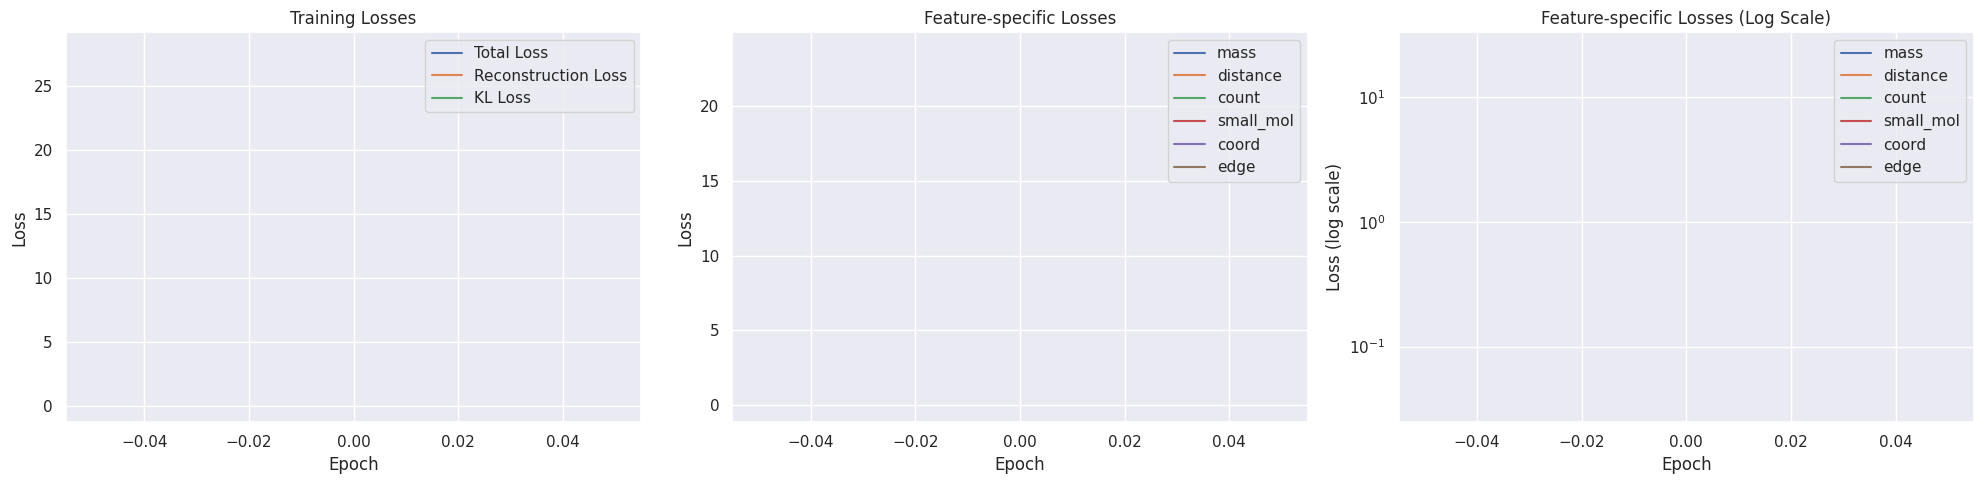

Epoch 2/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 23.6555
Raw KL loss: 0.1801
mu mean: -0.0360, std: 0.4348
logvar mean: -0.5777, std: 0.3665
mass: 1.3789
distance: 1.0365
count: 20.4753
small_mol: 0.0220
coord: 0.6392
edge: 0.1036


Epoch 2/10 [Train]:  12%|█▏        | 10/83 [00:30<04:16,  3.51s/it, loss=19.1915, recon=19.1530, kl=0.3849]


Detailed loss diagnostics:
Raw recon_loss: 18.7433
Raw KL loss: 0.3122
mu mean: -0.0375, std: 0.5563
logvar mean: -0.8390, std: 0.5031
mass: 1.1189
distance: 0.8763
count: 16.3172
small_mol: 0.0270
coord: 0.2995
edge: 0.1045


Epoch 2/10 [Train]:  24%|██▍       | 20/83 [01:01<03:14,  3.09s/it, loss=43.5623, recon=43.5543, kl=0.0803]


Detailed loss diagnostics:
Raw recon_loss: 12.9153
Raw KL loss: 0.0840
mu mean: -0.0297, std: 0.2907
logvar mean: -0.4027, std: 0.1882
mass: 0.7937
distance: 0.6158
count: 10.8758
small_mol: 0.0434
coord: 0.4805
edge: 0.1062


Epoch 2/10 [Train]:  25%|██▌       | 21/83 [01:02<02:42,  2.63s/it, loss=12.9237, recon=12.9153, kl=0.0840]

In [ ]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=128,  # Increased capacity
    latent_channels=64,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=num_epochs,    # More epochs
    beta=num_epochs / 100      # Lara_updated: old=0.05 ; Slightly increased KL weight
)

# Generator

In [132]:
import torch
from torch_geometric.data import Data
import numpy as np

# def calculate_normalization_params(graphs):
#     """
#     Calculate feature means and standard deviations from a list of graphs.
#     """
#     all_features = torch.cat([g.x for g in graphs], dim=0)
#     feature_means = all_features.mean(dim=0)
#     feature_stds = all_features.std(dim=0)
    
#     # Prevent division by zero
#     feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)
#     return feature_means, feature_stds


def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr


# def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.0):
#     """
#     Generate new protein graphs with diverse node features.
#     """
#     # Determine device
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     # Step 1: Calculate normalization parameters
#     feature_means, feature_stds = calculate_normalization_params(graphs)
#     print(f"Feature means: {feature_means}")
#     print(f"Feature stds: {feature_stds}")

#     model.eval()
#     model = model.to(device)

#     generated_graphs = []

#     with torch.no_grad():
#         # Step 2: Sample diverse latent vectors
#         z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

#         # Step 3: Generate graphs
#         for i in range(num_samples):
#             # Decode latent vector into node features
#             z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
#             decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=None)

#             # Unnormalize features
#             decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

#             # Extract coordinates and generate edges
#             coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
#             edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

#             # Create PyG Data object
#             graph = Data(
#                 x=decoded_features,
#                 edge_index=edge_index,
#                 edge_attr=edge_attr
#             )

#             generated_graphs.append(graph)

#     return generated_graphs


In [ ]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [135]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-3.5807e-09, -6.4279e-09,  1.1039e-08, -1.1668e-08, -3.3471e-09,
         5.8198e-09,  5.1713e-09, -1.5502e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[-7.0663e-01,  2.1465e+00, -3.3564e-01, -9.2107e-01,  3.5325e+00,
          7.2844e-02,  1.9128e+00,  1.9314e-01, -7.0872e-01,  9.8147e-01,
          5.3765e-01,  4.6414e-01, -1.2849e+00, -9.6652e-01, -7.7628e-01,
         -1.0126e+00,  2.9757e+00,  5.1640e-01, -1.6079e+00, -8.0438e-01,
         -3.1577e+00,  1.4066e+00, -1.7626e+00, -1.0732e+00, -1.5395e+00,
         -5.7910e-01, -2.3557e+00, -1.0246e+00,  1.0714e+00, -2.4492e-01,
          3.4668e-01,  5.6140e-01,  1.0732e+00,  1.2380e-01,  1.0552e+00,
          5.5236e-01,  2.8369e+00,  6.3136e-02,  1.7533e+00, -4.3987e+00,
         -6.4617e-01, -5.9184e-01,  2.0518e+00, -9.0847e-02,  3.2968e-01,
          3.2991e-01,  9.1288e-01, -2.2276e+00,  9.0626e-01, -3.1440e+00,
          9.8829e-01,  4.2749e-01, -3.058

In [110]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1010, -0.0707],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0772, -0.1010, -0.0708],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0770, -0.1009, -0.0706],
        ...,
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0778, -0.1015, -0.0710],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1009, -0.0708],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1010, -0.0706]])
  Feature std: tensor([[1.0238e-05, 1.0895e-05, 1.2091e-05,  ..., 4.4323e-03, 3.1091e-03,
         2.6492e-03],
        [9.6337e-06, 1.0251e-05, 1.1386e-05,  ..., 4.1997e-03, 2.8779e-03,
         2.4807e-03],
        [1.0455e-05, 1.1139e-05, 1.2360e-05,  ..., 4.6795e-03, 3.3558e-03,
         2.8303e-03],
        ...,
        [9.8658e-06, 1.0511e-05, 1.1676e-05,  ..., 4.1254e-03, 2.8894e-03,
         2.6298e-03],
        [9.5310e-06, 1.0152e-05, 1.1267e-05,  ..., 4.0964e-03, 2.8649e-03,


(test latest version)

In [96]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [97]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [98]:
def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    """
    Visualize a generated protein graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object representing the protein graph.
    - title: Title of the plot.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    for node in G.nodes(data=True):
        print(f"Node data: {node[1]['x']}")
        break

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
    map_mass_to_color(float(node[1]['x'][0])) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [
        max(10, node[1]['x'][3].item() * 50) for node in G.nodes(data=True)
    ]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [
        max(0.1, edge[2]['edge_attr'][0].item()) for edge in G.edges(data=True)
    ]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(title, fontsize=14)
    plt.show()


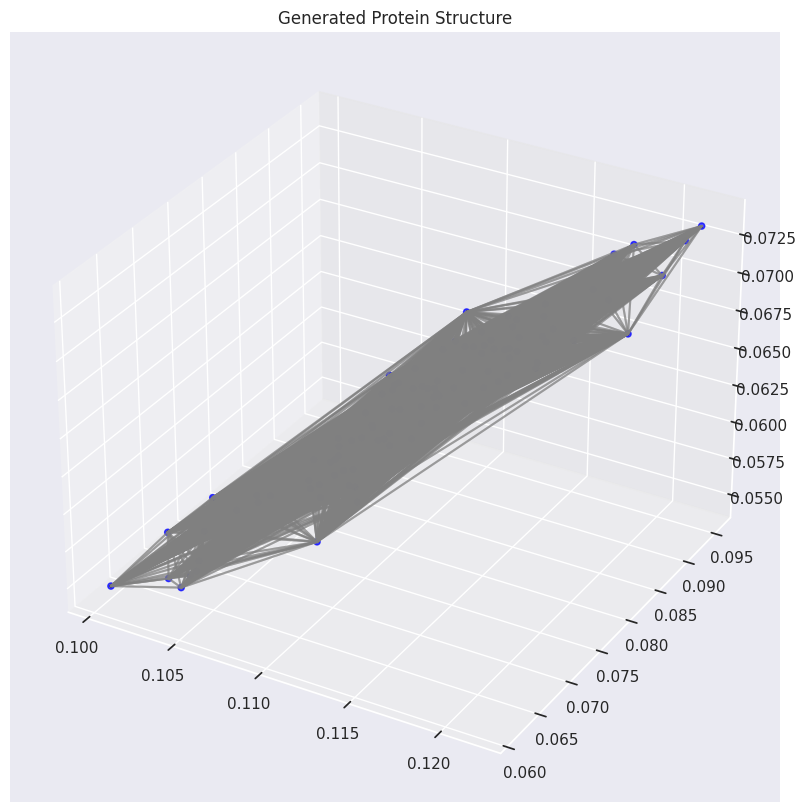

In [99]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_protein_structure_from_graph(generated_protein, title="Generated Protein Structure")


In [100]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [101]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

New generator: 

In [102]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(feature_means, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined